In [1]:
%reload_ext autoreload
%autoreload 2
# import matplotlib.pyplot as plt
import os
import torch
import logging
import time
from argparse import ArgumentParser

import cv2
import json_tricks as json
import numpy as np

from multi_camera.datajoint.sessions import Subject, Session, Recording


from pose_pipeline.utils.jupyter import play,play_grid
from pose_pipeline.pipeline import BlurredVideo,LiftingPerson,LiftingMethod,TopDownPerson,Video
from multi_camera.datajoint.multi_camera_dj import Calibration,PersonKeypointReconstruction,SingleCameraVideo, CalibratedRecording, MultiCameraRecording,PersonKeypointReconstructionMethod
from multi_camera.datajoint.sessions import Recording
from multi_camera.datajoint import calibrate_cameras

[2024-07-15 14:53:29,453][INFO]: Connecting pfirouzabadi@127.0.0.1:3306
[2024-07-15 14:53:29,545][INFO]: Connected pfirouzabadi@127.0.0.1:3306


In [7]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] ='1'
os.environ['PYOPENGL_PLATFORM'] = 'osmesa'
import numpy as np
%matplotlib inline
# %matplotlib nbagg
from typing import Callable, List, Tuple, Dict, Optional, Union
import jax
import jaxopt
from jax import vmap, jit
from jax import numpy as jnp
from tqdm import trange
from functools import partial

import cv2, PIL, os
from cv2 import aruco
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd


from multi_camera.analysis.camera import (
    robust_triangulate_points,
    triangulate_point,
    reprojection_error,
    reconstruction_error,
    get_checkboard_3d,
)


Read in Calibration files

In [3]:
import glob

calibration_files = glob.glob('./data/*143040*.mp4')
caps = [cv2.VideoCapture(f) for f in calibration_files]

[]


Charuco Board printed using following function

In [ ]:
aruco_dict_type = cv2.aruco.DICT_6X6_250
aruco_dict = cv2.aruco.getPredefinedDictionary(aruco_dict_type)
board = cv2.aruco.CharucoBoard((7, 5), 1, .8, aruco_dict)


In [3]:
rows, cols = (5,7)
square_size = 109.0

In [ ]:
from multi_camera.analysis.calibration import run_calibration, plot_cal

vid_base = '/mnt/CottonLab/mobile_system_data/20240523/m007/calibration_large_charuco_light_off_20240523_170251'
vid_path, vid_base = os.path.split(vid_base)

print(vid_path, vid_base)

entry = run_calibration(
    vid_base,
    vid_path,
    checkerboard_size=square_size,
    checkerboard_dim=(rows,cols),
    charuco = True,
    jax_cal=False,
    frame_skip=2,
    )

0.06

In [ ]:
if np.isnan(entry["reprojection_error"]):
    raise Exception(f"Calibration failed: {entry}")

if entry["reprojection_error"] > 0.3:
    print(entry)
    print(f'The error was {entry["reprojection_error"]}. Are you sure you would like to store this in the database? [Yes/No]')

    response = input()
    if response[0].upper() != "Y":
        print("Cancelling")
        raise Exception("Calibration failed")

# entry["recording_base"] = vid_base

# Calibration.insert1(entry)

In [ ]:
entry

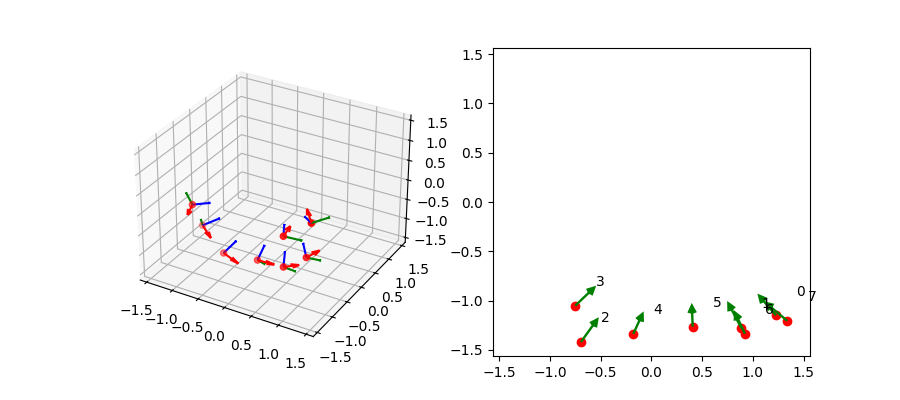

0.060395566288744956

In [8]:
%matplotlib widget

plot_cal(entry['camera_calibration'])

entry["reprojection_error"]

m007/calibration_large_charuco_light_off_20240523_170251

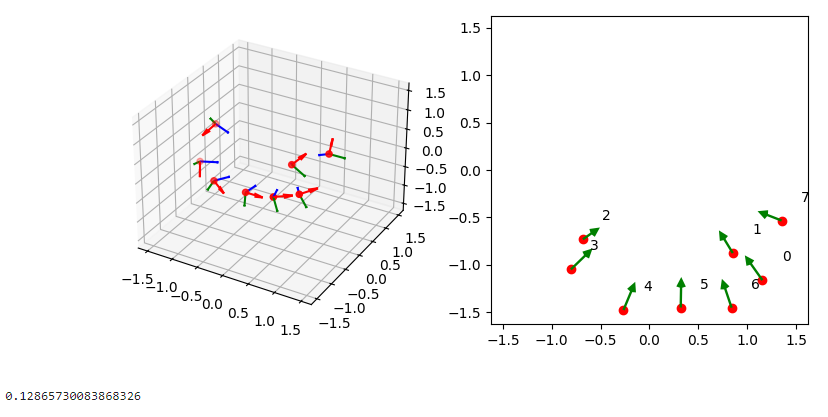

# Old/Original Aruco Testing Code

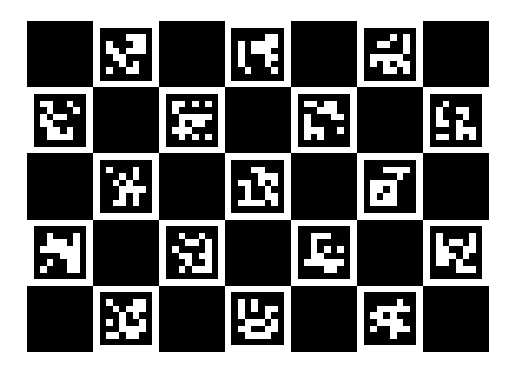

In [22]:
workdir = "./"
aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_6X6_250)
board = aruco.CharucoBoard((7, 5), 1, .8, aruco_dict)
# imboard = board.draw((4080, 4080))
img = cv2.aruco.CharucoBoard.generateImage(board, (4080, int(4080*5/7)), marginSize=100)

cv2.imwrite(workdir + "Charuco7x5.png", img)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.imshow(img, cmap = mpl.cm.gray, interpolation = "nearest")
ax.axis("off")
plt.show()

In [23]:
downsample = 1
images = []
for c in caps:
    c.set(cv2.CAP_PROP_POS_FRAMES, 0)
    ret, img = c.read()
    images.append(img)
    if not ret or img is None:
        break
def process_frame( idx, img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    # chessboard_flags = cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_NORMALIZE_IMAGE  # + cv2.CALIB_CB_FAST_CHECK

    gray_ds = cv2.resize(gray, (img.shape[1] // downsample, img.shape[0] // downsample))
    params = cv2.aruco.DetectorParameters_create()
    corners, ids, _ = cv2.aruco.detectMarkers(gray_ds, aruco_dict, parameters=params)
    if not shape:
        shape = img.shape
    if len(corners) > 0:
        corners = corners * downsample

        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

        cv2.aruco.drawDetectedMarkers(gray, corners, ids)
        
        for corner in corners:
            cv2.cornerSubPix(gray, corner,
                                winSize = (11,11),
                                zeroZone = (-1,-1),
                                criteria = criteria)
        corners2 , ids2, charuco_retval = corners, ids, 0
        # charuco_retval, corners2, ids2 = cv2.aruco.interpolateCornersCharuco(corners, ids, gray, board)
        if corners2 is not None :

            corners.append(corners2)
            ids.append(ids2)
            frames.append(idx)

        # corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        # corners.append(corners2)
        if save_images:
            images.append(img)
    else:
        charuco_retval = 0

    if save_images:
        last_image = img

    return charuco_retval

In [ ]:
def read_chessboards(images):
    print("POSE ESTIMATION STARTS:")
    allCorners = []
    allIds = []
    decimator = 0
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.00001)


    for im in images:
        frame = cv2.imread(im)
        # frame = im
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        # gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        print("=> Processing image {0}".format(gray.shape))
        
        corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(gray, aruco_dict)
        if len(corners)>0:
            # print(corners[0][0])

            for corner in corners:
                    cv2.cornerSubPix(gray, corner,
                                        winSize = (3,3),
                                        zeroZone = (-1,-1),
                                        criteria = criteria)
            print(len(corners), len(ids))
            print(corners[0][0])
            corners, ids, _, _ = cv2.aruco.refineDetectedMarkers(gray, board, corners, ids, rejectedImgPoints)
            # print(res)
            print(corners[0][0])
            print(len(corners), len(ids))

            res2 = cv2.aruco.interpolateCornersCharuco(corners,ids,gray,board,minMarkers=0)
            # print(ids)
            print(res2[1].shape, len(res2[2]))

            if res2[1] is not None and res2[2] is not None and len(res2[1])>3 and decimator%1==0:
                allCorners.append(res2[1])
                allIds.append(res2[2])
            
                print('corners size ',res2[1].shape)


                # gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
                # aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250)
                # parameters =  aruco.DetectorParameters_create()
                # corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict,
                                                                #   parameters=parameters)
                # _, charuco_corners, charuco_ids = aruco.interpolateCornersCharuco(corners, ids, gray, board)
                # SUB PIXEL DETECTION
                charuco_corners=res2[1]
                charuco_ids=res2[2]

                frame_markers = aruco.drawDetectedMarkers(frame.copy(), corners, ids, borderColor=(255, 0, 0))
                plt.imshow(frame_markers)
                # plt.pause(0.01)
                image = aruco.drawDetectedCornersCharuco(frame_markers, charuco_corners, charuco_ids,cornerColor = (0, 0, 250))
                plt.figure()
                plt.imshow(image)
                for i in range(len(ids)):
                    image = cv2.putText(image, 
                                        str(ids[i][0]), 
                                        (int(charuco_corners[i][0][0]),int(charuco_corners[i][0][1])), 
                                        cv2.FONT_HERSHEY_SIMPLEX,  
                                    2, (255, 50, 50) ,2, cv2.LINE_AA)
                plt.imshow(image)
                plt.pause(0.01)
        # decimator+=1

    imsize = gray.shape
    return allCorners,allIds,imsize

In [ ]:
images = ["./padded_chessboard.tiff", "./padded_chessboard180.tiff"]
images = ["./IMG_9089.jpg","./IMG_9089_r.jpg","./IMG_9090.jpg", "./IMG_9091.jpg","./IMG_9092.jpg"]

In [ ]:
allCorners,allIds,imsize=read_chessboards(images)
allIds

In [ ]:
def calibrate_camera(allCorners,allIds,imsize):
    """
    Calibrates the camera using the dected corners.
    """
    print("CAMERA CALIBRATION")

    cameraMatrixInit = np.array([[ 1000.,    0., imsize[0]/2.],
                                 [    0., 1000., imsize[1]/2.],
                                 [    0.,    0.,           1.]])

    distCoeffsInit = np.zeros((5,1))
    flags = (cv2.CALIB_USE_INTRINSIC_GUESS + cv2.CALIB_RATIONAL_MODEL + cv2.CALIB_FIX_ASPECT_RATIO)
    #flags = (cv2.CALIB_RATIONAL_MODEL)
    (ret, camera_matrix, distortion_coefficients0,
     rotation_vectors, translation_vectors,
     stdDeviationsIntrinsics, stdDeviationsExtrinsics,
     perViewErrors) = cv2.aruco.calibrateCameraCharucoExtended(
                      charucoCorners=allCorners,
                      charucoIds=allIds,
                      board=board,
                      imageSize=imsize,
                      cameraMatrix=cameraMatrixInit,
                      distCoeffs=distCoeffsInit,
                      flags=flags,
                      criteria=(cv2.TERM_CRITERIA_EPS & cv2.TERM_CRITERIA_COUNT, 10000, 1e-9))

    return ret, camera_matrix, distortion_coefficients0, rotation_vectors, translation_vectors

In [ ]:
%time ret, mtx, dist, rvecs, tvecs = calibrate_camera(allCorners,allIds,imsize)

CAMERA CALIBRATION
CPU times: user 3.54 s, sys: 94.1 ms, total: 3.63 s
Wall time: 145 ms


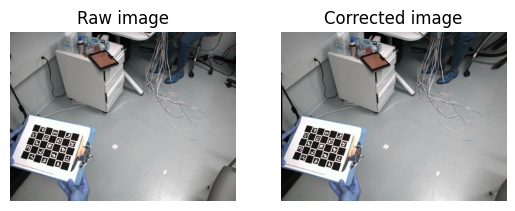

In [ ]:
i=0 # select image id
plt.figure()
frame = images[i]
img_undist = cv2.undistort(frame,mtx,dist,None)
plt.subplot(1,2,1)
plt.imshow(frame)
plt.title("Raw image")
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(img_undist)
plt.title("Corrected image")
plt.axis("off")
plt.show()

In [ ]:
corners[0][0][0]

array([2189.9282, 2248.0798], dtype=float32)

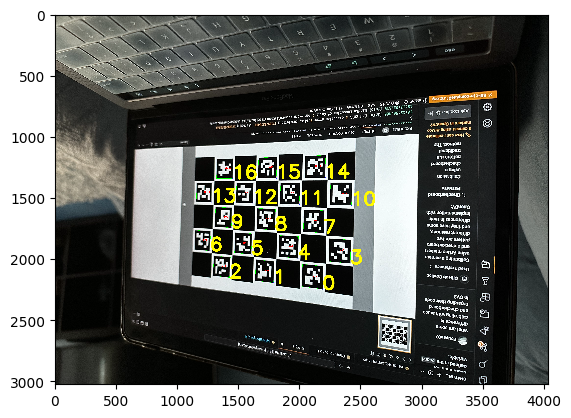

In [ ]:
plt.figure()
# image = frame_markers.copy()
for i in range(len(ids)):
    image = cv2.putText(images, 
                        str(ids[i][0]), 
                        (int(corners[i][0][0][0]),int(corners[i][0][0][1])), 
                        cv2.FONT_HERSHEY_SIMPLEX,  
                    5, (255, 250, 0) ,20, cv2.LINE_AA)
plt.imshow(image, interpolation = "nearest")

plt.show()

In [23]:
entry.keys()

dict_keys(['cal_timestamp', 'camera_config_hash', 'num_cameras', 'camera_names', 'camera_calibration', 'reprojection_error', 'calibration_points', 'calibration_shape'])

In [18]:
cal3d = triangulate_point(camera_params, checkerboard_points[:, 0])

x0 = cal3d[0]
x = cal3d[5] - x0
z = cal3d[18] - x0

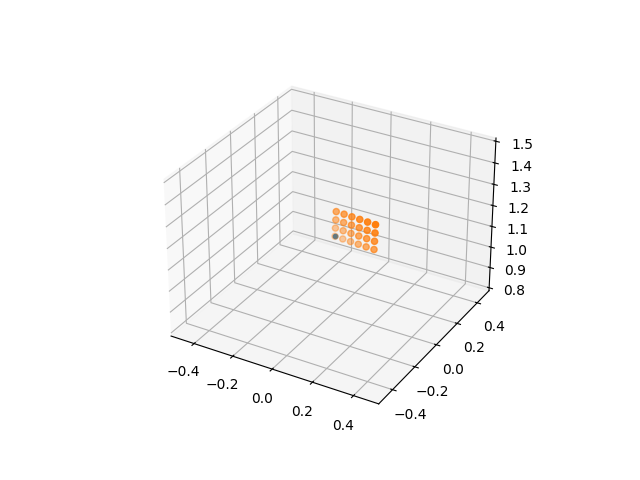

In [38]:
ax = plt.figure().add_subplot(111,projection='3d')
ax.set_xlim([-0.5, 0.5])
ax.set_ylim([-0.5, 0.5])
ax.set_zlim([0.8, 1.5])

ax.scatter(cal3d[18,0],cal3d[18,1],cal3d[18,2],'r',s=10)
ax.scatter(cal3d[:,0],cal3d[:,1],cal3d[:,2])


In [16]:
import numpy as np
# checkerboard_points = np.zeros((8, 10, 24, 3)) * jnp.nan

calibration_points = entry['calibration_points']
checkerboard_points = entry['calibration_points']
camera_params = entry['camera_calibration']

x0, board_rotation = extract_origin(camera_params, checkerboard_points[:, 5:])
x0
camera_params_zeroed = shift_calibration(camera_params, x0, board_rotation, zoffset=0)
camera_params_zeroed

{'dist': array([[-0.15376282,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.01628816,  0.        ,  0.        ,  0.        ,  0.        ],
        [-0.18234472,  0.        ,  0.        ,  0.        ,  0.        ],
        [-0.17034325,  0.        ,  0.        ,  0.        ,  0.        ],
        [-0.0455877 ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.04561709,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.00445027,  0.        ,  0.        ,  0.        ,  0.        ],
        [-0.18803985,  0.        ,  0.        ,  0.        ,  0.        ]]),
 'mtx': array([[1.79935227, 1.79935227, 1.0235    , 0.7675    ],
        [1.95945386, 1.95945386, 1.0235    , 0.7675    ],
        [1.82537549, 1.82537549, 1.0235    , 0.7675    ],
        [1.80200491, 1.80200491, 1.0235    , 0.7675    ],
        [1.33337688, 1.33337688, 1.0235    , 0.7675    ],
        [2.23311625, 2.23311625, 1.0235    , 0.7675    ],
        [1.58064605, 1.58064605, 1.

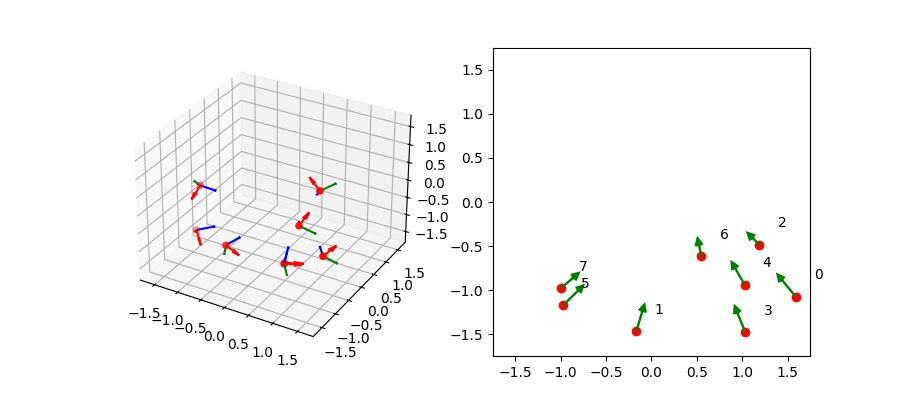

In [17]:
plot_cal(camera_params_zeroed)
